In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import os 
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
klin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[1]
stages = np.linspace(0.1, 1.0, 5, endpoint=True)

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

ipklin = iuspline(klin, plin)

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import mesh_tensorflow as mtf

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
# Define the cluster
# cluster = tf.train.ClusterSpec({"mesh": ["localhost:2222", "localhost:2223"]})

# import flowpm.mesh_ops as mpm


mesh_hosts = ["localhost:%d"%(8222+j) for j in range(4)]

# Create a cluster from the mesh hosts.                                                                                                                                                                                                                                                                                                                                  
cluster = tf.train.ClusterSpec({"mesh": mesh_hosts, "master":["localhost:8488"]})

# Create a server for local mesh members                                                                                                                                                                                                                                                                                                                                 
server = tf.train.Server(cluster,
                       job_name="master",
                       task_index=0)

devices = ['/job:mesh/task:%d'%i for i in range(cluster.num_tasks("mesh"))]


In [7]:
import sys
sys.path.pop(6)
sys.path.append('../')
sys.path.append('../flowpm/')


In [8]:
# import flowpm.mesh_ops as mpm
import flowpm
from flowpm import mesh_ops
from flowpm import mesh_utils
from flowpm import mesh_kernels

import flowpm.mesh_utils as mpu
import flowpm.mtfpm as fpm
import tensorflow_probability as tfp


graph = mtf.Graph()
mesh = mtf.Mesh(graph, "my_mesh")

batch_size = 1
boxsize=100
nc = 64       # Native resolution of the grid

# Parameters of the small scales decomposition
n_block_x = 2
n_block_y = 2
n_block_z = 1
halo_size = 16

# Parameters of the large scales decomposition
downsampling_factor = 2
lnc = nc // 2**downsampling_factor 

fx_dim = mtf.Dimension("nx", nc)
fy_dim = mtf.Dimension("ny", nc)
fz_dim = mtf.Dimension("nz", nc)

# Dimensions of the low resolution grid
x_dim = mtf.Dimension("nx_lr", lnc)
y_dim = mtf.Dimension("ny_lr", lnc)
z_dim = mtf.Dimension("nz_lr", lnc)

tx_dim = mtf.Dimension("tx_lr", lnc)
ty_dim = mtf.Dimension("ty_lr", lnc)
tz_dim = mtf.Dimension("tz_lr", lnc)

nx_dim = mtf.Dimension('nx_block', n_block_x)
ny_dim = mtf.Dimension('ny_block', n_block_y)
nz_dim = mtf.Dimension('nz_block', n_block_z)

sx_dim = mtf.Dimension('sx_block', nc//n_block_x)
sy_dim = mtf.Dimension('sy_block', nc//n_block_y)
sz_dim = mtf.Dimension('sz_block', nc//n_block_z)

batch_dim = mtf.Dimension("batch", batch_size)
pk_dim = mtf.Dimension("npk", len(plin))
pk = mtf.import_tf_tensor(mesh, plin.astype('float32'), shape=[pk_dim])

In [9]:
# kvec for low resolution grid
kvec_lr = flowpm.kernels.fftk([lnc, lnc, lnc], symmetric=False) 

kx_lr = mtf.import_tf_tensor(mesh, kvec_lr[0].squeeze().astype('float32')/ 2**downsampling_factor, shape=[tx_dim])
ky_lr = mtf.import_tf_tensor(mesh, kvec_lr[1].squeeze().astype('float32')/ 2**downsampling_factor, shape=[ty_dim])
kz_lr = mtf.import_tf_tensor(mesh, kvec_lr[2].squeeze().astype('float32')/ 2**downsampling_factor, shape=[tz_dim])
kv_lr = [ky_lr, kz_lr, kx_lr]

# kvec for high resolution blocks
padded_sx_dim = mtf.Dimension('padded_sx_block', nc//n_block_x+2*halo_size)
padded_sy_dim = mtf.Dimension('padded_sy_block', nc//n_block_y+2*halo_size)
padded_sz_dim = mtf.Dimension('padded_sz_block', nc//n_block_z+2*halo_size)
kvec_hr = flowpm.kernels.fftk([nc//n_block_x+2*halo_size, nc//n_block_y+2*halo_size, nc//n_block_z+2*halo_size], symmetric=False)

kx_hr = mtf.import_tf_tensor(mesh, kvec_hr[0].squeeze().astype('float32'), shape=[padded_sx_dim])
ky_hr = mtf.import_tf_tensor(mesh, kvec_hr[1].squeeze().astype('float32'), shape=[padded_sy_dim])
kz_hr = mtf.import_tf_tensor(mesh, kvec_hr[2].squeeze().astype('float32'), shape=[padded_sz_dim])
kv_hr = [kx_hr, ky_hr, kz_hr]

In [10]:
lr_shape = [batch_dim, 
            x_dim, y_dim, z_dim]

In [11]:
hr_shape = [batch_dim, 
            nx_dim, ny_dim, nz_dim,
            sx_dim, sy_dim, sz_dim]

In [12]:
part_shape = [batch_dim, fx_dim, fy_dim, fz_dim]

In [13]:
lr_shape

[Dimension(name='batch', size=1),
 Dimension(name='nx_lr', size=16),
 Dimension(name='ny_lr', size=16),
 Dimension(name='nz_lr', size=16)]

In [14]:
hr_shape

[Dimension(name='batch', size=1),
 Dimension(name='nx_block', size=2),
 Dimension(name='ny_block', size=2),
 Dimension(name='nz_block', size=1),
 Dimension(name='sx_block', size=32),
 Dimension(name='sy_block', size=32),
 Dimension(name='sz_block', size=64)]

In [15]:
hr_shape[1:4]

[Dimension(name='nx_block', size=2),
 Dimension(name='ny_block', size=2),
 Dimension(name='nz_block', size=1)]

In [16]:
k_dims = [tx_dim, ty_dim, tz_dim]

In [17]:
initial_conditions = flowpm.linear_field(nc,          # size of the cube
                                         boxsize,     # Physical size of the cube
                                         ipklin,      # Initial powerspectrum
                                         batch_size=batch_size)
initc = tf.reshape(initial_conditions, [1, 2, 2, 1, nc//2, nc//2, nc])

field = mtf.import_tf_tensor(mesh, initc, shape=hr_shape)


for block_size_dim in hr_shape[-3:]:
    field = mtf.pad(field, [halo_size, halo_size], block_size_dim.name)

for blocks_dim, block_size_dim in zip(hr_shape[1:4], field.shape[-3:]):
    field = mesh_ops.halo_reduce(field, blocks_dim, block_size_dim, halo_size)

field = mtf.reshape(field, field.shape+[mtf.Dimension('h_dim', 1)])
high = field
low = mesh_utils.downsample(field, downsampling_factor, antialias=True)

low = mtf.reshape(low, low.shape[:-1])
high = mtf.reshape(high, high.shape[:-1])

for block_size_dim in hr_shape[-3:]:
    low = mtf.slice(low, halo_size//2**downsampling_factor, block_size_dim.size//2**downsampling_factor, block_size_dim.name)
#low = mtf.reshape(low, lr_shape)

low = mtf.slicewise(lambda x: x[:,0,0,0],
                    [low],
                    output_dtype=tf.float32,
                    output_shape=lr_shape,
                    name='my_dumb_reshape',
                    splittable_dims=lr_shape[:-1]+hr_shape[:4])

In [18]:
state = fpm.lpt_init(low, high, 0.1, kv_lr, kv_hr, halo_size, hr_shape, lr_shape, k_dims, part_shape[1:],
                            downsampling_factor=downsampling_factor, antialias=True,)

Tensor[FFT3D:0, Shape[batch=1, ty_lr=16, tz_lr=16, tx_lr=16], <dtype: 'complex64'>]
[Tensor[import_2:0, Shape[ty_lr=16], <dtype: 'float32'>], Tensor[import_3:0, Shape[tz_lr=16], <dtype: 'float32'>], Tensor[import_1:0, Shape[tx_lr=16], <dtype: 'float32'>]]


In [19]:
# Here we can run our nbody
final_state = state # fpm.nbody(state, stages, lr_shape, hr_shape, k_dims, kv_lr, kv_hr, halo_size, downsampling_factor=downsampling_factor)

In [20]:
# paint the field
final_field = mtf.zeros(mesh, shape=hr_shape)
for block_size_dim in hr_shape[-3:]:
    final_field = mtf.pad(final_field, [halo_size, halo_size], block_size_dim.name)
final_field = mpu.cic_paint(final_field, final_state[0], halo_size)
# Halo exchange
for blocks_dim, block_size_dim in zip(hr_shape[1:4], final_field.shape[-3:]):
    final_field = mesh_ops.halo_reduce(final_field, blocks_dim, block_size_dim, halo_size)
# Remove borders
for block_size_dim in hr_shape[-3:]:
    final_field = mtf.slice(final_field, halo_size, block_size_dim.size, block_size_dim.name)

In [21]:
#final_field = mtf.reshape(final_field,  [batch_dim, fx_dim, fy_dim, fz_dim])
final_field = mtf.slicewise(lambda x: x[:,0,0,0],
                    [final_field],
                    output_dtype=tf.float32,
                    output_shape=[batch_dim, fx_dim, fy_dim, fz_dim],
                    name='my_dumb_reshape',
                    splittable_dims=part_shape[:-1]+hr_shape[:4])


In [22]:
# Let's have a look!
devices = ["/job:mesh/task:%d"%i for i in range(cluster.num_tasks("mesh"))]
mesh_shape = [("row", 2), ("col", 2)]
layout_rules = [("nx_lr", "row"), ("ny_lr", "col"),
                ("nx", "row"), ("ny", "col"),
                ("ty_lr", "row"), ("tz_lr", "col"),
                ("nx_block","row"), ("ny_block","col")]

mesh_impl = mtf.placement_mesh_impl.PlacementMeshImpl(
    mesh_shape, layout_rules, devices)

lowering = mtf.Lowering(graph, {mesh:mesh_impl})

tf_field = lowering.export_to_tf_tensor(final_field)

FFT changing split 1
FFT changing split 0
iFFT changing split 0
iFFT changing split 1
iFFT changing split 0
iFFT changing split 1
iFFT changing split 0
iFFT changing split 1
INFO:tensorflow:Counters:
conv3d: 3.06e+08
 conv3d/forward: 3.06e+08
conv3d_transpose: 3.64e+09
 conv3d_transpose/forward: 3.64e+09
conv3d_transpose_unique: 3.64e+09
 conv3d_transpose_unique/forward: 3.64e+09
conv3d_unique: 3.06e+08
 conv3d_unique/forward: 3.06e+08
einsum: 8.03e+05
einsum_unique: 8.03e+05
output: 1.93e+08
 output/AddOperation: 3.81e+07
 output/Constant: 2.62e+05
 output/Conv3dOperation: 9.83e+05
 output/Conv3dTransposeOperation: 1.06e+07
 output/EinsumOperation: 8.03e+05
 output/FFT3DOperation: 4.1e+03
 output/ImportOperation: 2.99e+05
 output/IndicesOperation: 7.86e+05
 output/PadOperation: 3.54e+07
 output/ReshapeOperation: 2.21e+07
 output/ScalarMultiplyOperation: 2.38e+06
 output/ShiftOperation: 8.59e+06
 output/SliceOperation: 1.11e+07
 output/SlicewiseOperation: 6.03e+07
 output/StackOperatio

In [23]:
# Compute evolution of the field using standard FlowPM
state = flowpm.lpt_init(initial_conditions, a0=0.1,order=1) 
final_state = state# flowpm.nbody(state,  stages, nc)
tfinal_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

In [24]:
# with tf.Session("grpc://localhost:2222") as sess:
#     fin_ref = sess.run(tfinal_field )
#with tf.Session("grpc://localhost:8488") as sess:
#    fin_ref = sess.run(tfinal_field )

In [25]:
with tf.Session("grpc://localhost:8488") as sess:
    fin_ref, fin = sess.run([tfinal_field , tf_field])

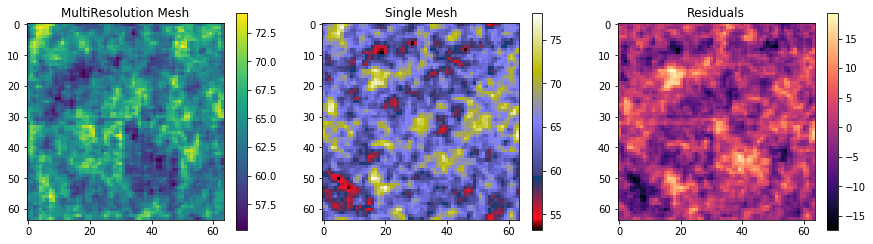

In [27]:
figure(figsize=(15,4))
subplot(131)
imshow((fin)[0,].sum(axis=2)); colorbar();
title('MultiResolution Mesh')
subplot(132)
imshow(fin_ref[0,].sum(axis=2),cmap='gist_stern'); colorbar();
title('Single Mesh')
subplot(133)
imshow((fin_ref - fin)[0,].sum(axis=2),cmap='magma'); colorbar();
title('Residuals')
savefig('figname.png',  transparent=False)

In [38]:
from nbodykit.lab import *
from nbodykit import setup_logging, style
from pmesh.pm import ParticleMesh as PM

In [43]:
pm = PM(Nmesh=[nc]*3, BoxSize=[boxsize]*3)


In [49]:
k = FFTPower(pm.create(mode='real', value=fin), mode='1d').power['k']
pkf = FFTPower(pm.create(mode='real', value=fin), mode='1d').power['power']
pkfref = FFTPower(pm.create(mode='real', value=fin_ref), mode='1d').power['power']
pkx = FFTPower(pm.create(mode='real', value=fin), second=pm.create(mode='real', value=fin_ref), mode='1d').power['power']

/home/chirag/anaconda3/envs/tflow2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: argument mode is deprecated. use type=real instead
  """Entry point for launching an IPython kernel.
/home/chirag/anaconda3/envs/tflow2/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: argument mode is deprecated. use type=real instead
  
/home/chirag/anaconda3/envs/tflow2/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: argument mode is deprecated. use type=real instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/chirag/anaconda3/envs/tflow2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: argument mode is deprecated. use type=real instead
  after removing the cwd from sys.path.


/home/chirag/anaconda3/envs/tflow2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/chirag/anaconda3/envs/tflow2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 0, 'k (h/Mpc)')

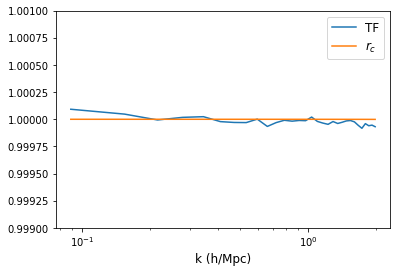

In [58]:
plt.plot(k, pkf/pkfref, label='TF')
plt.plot(k, pkx/(pkfref*pkf)**0.5, label='$r_c$')
plt.semilogx()
plt.ylim(0.999, 1.001)
plt.legend(fontsize=12)
plt.xlabel('k (h/Mpc)', fontsize=12)